In [657]:
from Stable_SSM_EM import *
import numpy as np
import pandas as pd

from dateutil import tz
from astral import Astral
from pandas.tseries.offsets import *
import glob

from Utilities import *
from ModelTest import loadTestSets

from matplotlib.font_manager import FontProperties

# TODO
* Why is KTL $P_{\rm solar}$ so small???

In [2]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

# Load data
### Bear Trap
Very little snow in 2014, so not very useful.

In [138]:
bear_trap_path = "../raw_data/american_river/bear_trap/level_0/June 2014/"

# Get list of bear trap nodes. Shifting indices by -1...
bear_trap_nodes = [d for d in os.listdir(bear_trap_path) if not d.startswith(".") and not d.endswith(".swp")]
bear_trap_nodes = sorted(bear_trap_nodes, key=lambda x: int(x[12:].split(".")[0]))

# Load the data
dfs_arho_bear_trap = []

for n, d in enumerate(bear_trap_nodes):
    if not d.startswith("."):
        print d
        df_cur = pd.read_csv(arho_data_path + d, delimiter=",", comment="#")
        
        # Rename columns
        df_cur.columns = ["Time"] + [col + "_%i" % n for col in df_cur.columns if col != "Time"]
        df_cur["Time"] = pd.to_datetime(df_cur["Time"])
        
        dfs_arho_bear_trap.append(df_cur)

bt_f6e2_node1.csv
bt_f6e4_node2.csv
bt_f925_node3.csv
bt_f938_node4.csv
bt_f9c3_node6.csv
bt_f9aa_node7.csv
bt_f98f_node8.csv
bt_f9c3_node9.csv
bt_f9c4_node10.csv


In [139]:
# Merge all datasets
df_arho_bear_trap = reduce(lambda x, y: pd.merge(x, y, on="Time", how="outer", suffixes=("", "")), dfs_arho_bear_trap)

### Duncan Peak

In [382]:
wsn_name = "Duncan Peak"
duncan_peak_base_path = "../raw_data/american_river/duncan_peak/"
duncan_peak_path = duncan_peak_base_path + "level_1/wy_2015/"

# Get list of bear trap nodes. Shifting indices by -1...
duncan_peak_nodes = [d for d in os.listdir(duncan_peak_path) if not d.startswith(".") and not d.endswith(".swp")]
duncan_peak_nodes = sorted(duncan_peak_nodes, key=lambda x: int(x[22:].split(".")[0]))

# Load the data
dfs_arho_duncan_peak = []

for n, d in enumerate(duncan_peak_nodes):
    if not d.startswith("."):
        print d
        # Replace -999 (error value) with nan
        df_cur = pd.read_csv(duncan_peak_path + d, delimiter=",", comment="#").replace(-999, np.nan)
        
        # Use pacific time column. Rename columns to append node number.
        df_cur.columns = ["P_time"] + [col + "_%i" % n for col in df_cur.columns if col != "P_time"]
        df_cur["P_time"] = pd.to_datetime(df_cur["P_time"])
        
        dfs_arho_duncan_peak.append(df_cur)

DPK_WY2015_15min_node_1.csv


KeyboardInterrupt: 

In [207]:
# Merge all datasets
df_arho_duncan_peak = reduce(lambda x, y: pd.merge(x, y, on="P_time", how="outer", suffixes=("", "")), dfs_arho_duncan_peak)

In [211]:
# Save merged dataset
df_arho_duncan_peak.to_csv(duncan_peak_base_path + "merged_outliers_removed/duncan_peak.csv")

In [387]:
# Read existing merged dataset
df_arho_duncan_peak = pd.read_csv(duncan_peak_base_path + "merged_outliers_removed/duncan_peak.csv")

In [388]:
# Extract values
y_hs_raw = df_arho_duncan_peak[["snow_depth(mm)_" + str(s) for s in range(len(duncan_peak_nodes))]].values
y_t_raw = df_arho_duncan_peak[["Temp_C1(DegC)_" + str(s) for s in range(len(duncan_peak_nodes))]].values
y_rh_raw = df_arho_duncan_peak[["RH(%)_" + str(s) for s in range(len(duncan_peak_nodes))]].values
y_rad_raw = df_arho_duncan_peak[["solar(wm-2)_" + str(s) for s in range(len(duncan_peak_nodes))]].values
times = pd.to_datetime(df_arho_duncan_peak["P_time"]).values

### Kettle Rock

In [3]:
# Info on what's available
feather_wsns = ["KTL", "GRZL"]

# Choose a network
df_feather_ktl = pd.read_csv("../raw_data/feather_data/%s.csv" % feather_wsns[0])

# Extract values
y_hs_ktl = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_ktl = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_ktl = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values
y_rad_ktl = df_feather_ktl["solar_rad_8"].values
times = pd.to_datetime(df_feather_ktl["time"])

# Convert times to CA ones
utc_zone = tz.gettz("UTC")
ca_zone = tz.gettz("America/Los_Angeles")
times = np.array([t.replace(tzinfo=utc_zone).astimezone(ca_zone) for t in times])

# Get dawn/dusk times
astral = Astral()
astral.solar_depression = "civil"
city = astral["Sacramento"]

def get_dawn_dusk(ts):
    return np.array([city.sun(t)["sunrise"] for t in ts]), np.array([city.sun(t)["sunset"] for t in ts])

#### Not necessary right now

In [3]:
# Get dawn/dusk times
astral = Astral()
astral.solar_depression = "civil"
city = astral["Sacramento"]

def get_dawn_dusk(ts):
    return np.array([city.sun(t)["sunrise"] for t in ts]), np.array([city.sun(t)["sunset"] for t in ts])

# Overview

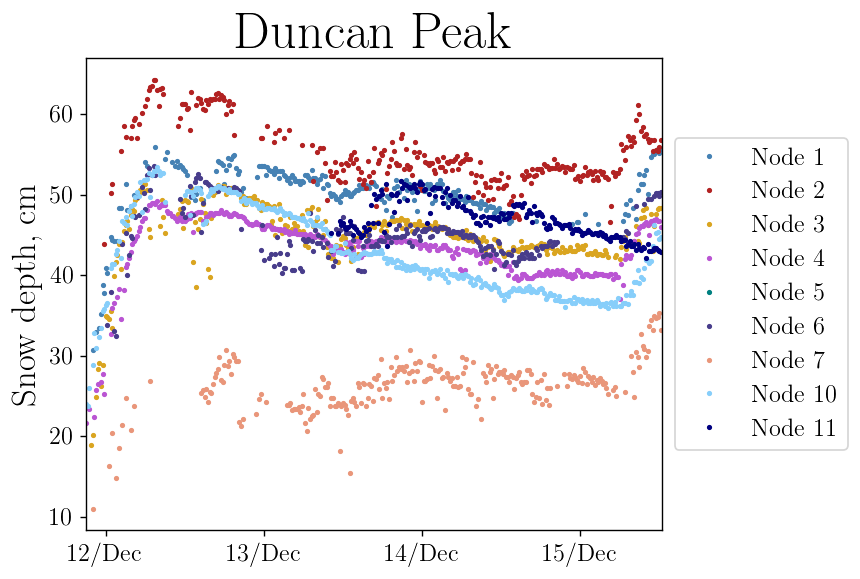

In [668]:
plt.figure(figsize=(7, 5))

ti, tf = 6900, 7250

ms = 4
for s, c in zip(sorted([2, 0, 1, 3, 4, 5, 6, 9, 10]), colors):
    #if s == 2:
    #    ms = 3
    #else:
    #    ms = 1
    plt.plot(times[ti:tf], 0.1*y_hs_raw[ti:tf, s], '.', markersize=ms, color=c, label="Node %i" % (s+1))

plt.xlim(times[ti], times[tf])
plt.ylabel("Snow depth, cm")
plt.title(wsn_name)

### Formatting
plt.xlim(times[ti], times[tf])
# fontP = FontProperties()
# fontP.set_size('small')
# plt.legend(prop = fontP)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.85, box.height])
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.ylabel("Snow depth, cm", fontsize=20)
plt.title(r"Duncan Peak", fontsize=30)

# Change tick font size
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
# Use fewer x ticks
plt.xticks(times[ti+12:tf:96], [pd.to_datetime(t).strftime('%d/%b') for t in times[ti+12:tf:96]])

plt.savefig("../presentations/uc_water/figures/overview.png", bbox_inches='tight', dpi=500)

# Gap histogram

In [229]:
gapSizes = []

tStart = 10000

for series in y_hs_raw.T:
    curGapSizes = []
    
    curGapSize = 0
    # Loop over values in series
    for v in series[tStart:]:
        if np.isnan(v):
            curGapSize = curGapSize + 1
        elif curGapSize > 0:
            # Append current gap size if it's nonzero and a non-nan value was encountered
            gapSizes.append(curGapSize)
            curGapSize = 0
    
# Get total list of gap sizes for the whole dataset
gapSizes = np.asarray(gapSizes)

(0, 600)

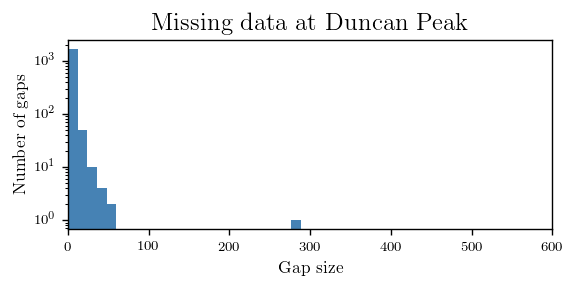

In [299]:
plt.figure(figsize=(5, 2))

plt.hist(gapSizes, bins=50, range=[0, 600])
plt.yscale("log")
plt.xlabel("Gap size")
plt.ylabel("Number of gaps")
plt.title("Missing data at " + wsn_name)
plt.xlim(0, 600)

# EM example

In [575]:
n_LF = 4
max_it = 100

sensors = range(y_hs_raw.shape[1])
sensors.remove(7)
sensors.remove(8)

ti, tf = 6900, 7250 #7400, 7525
Y = y_hs_raw[ti:tf, sensors].T

# Nan out some key data for a sensor
sensor_of_interest = 3
Y_nand = Y.copy()
ti_gap, tf_gap = 6915, 7165 #7450, 7487
Y_nand[sensor_of_interest, (ti_gap-ti):(tf_gap-ti)] = np.nan

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y_nand, U, V, ss, s_list, n_LF, max_it)

Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)

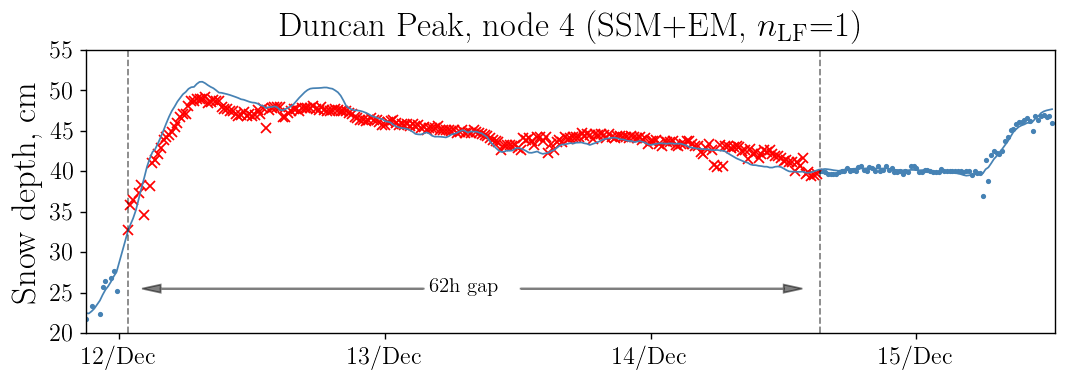

In [655]:
test_mse = np.nanmean(np.square(Y[sensor_of_interest, (ti_gap-ti):(tf_gap-ti)] - Y_hat[sensor_of_interest, (ti_gap-ti):(tf_gap-ti)]))

plt.figure(figsize=(10, 3))

plt.plot(times[ti:tf], 0.1*Y_nand[sensor_of_interest, :], '.', markersize=4.0, color=colors[0])
# Mark removed points with xs
plt.plot(times[ti_gap:tf_gap], 0.1*Y[sensor_of_interest, (ti_gap-ti):(tf_gap-ti)], 'x', markersize=6.0, color="r")
plt.plot(times[ti:tf], 0.1*Y_hat[sensor_of_interest, :], '-', linewidth=1, color=colors[0])

# Mark beginning and end of time gap
plt.plot(2*[times[ti_gap]], [20, 55], '--k', alpha=0.5, linewidth=1)
plt.plot(2*[times[tf_gap]], [20, 55], '--k', alpha=0.5, linewidth=1)
plt.text(times[ti_gap+109], 25, str((times[tf_gap] - times[ti_gap]).astype('timedelta64[h]'))[0:2] + "h gap")
plt.arrow(times[ti_gap+107], 25.5, -0.99, 0, head_width=1, head_length=0.07, fc='k', ec='k', alpha=0.5)
plt.arrow(times[ti_gap+142], 25.5, 0.99, 0, head_width=1, head_length=0.07, fc='k', ec='k', alpha=0.5)

### Formatting
plt.xlim(times[ti], times[tf])
plt.ylim(20, 55)

plt.ylabel("Snow depth, cm", fontsize=20)
plt.title(r"Duncan Peak, node %i (SSM+EM, $n_{\rm LF}$=%i)" % (sensor_of_interest+1, n_LF), fontsize=20)

# Change tick font size
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
# Use fewer x ticks
plt.xticks(times[ti+12:tf:96], [pd.to_datetime(t).strftime('%d/%b') for t in times[ti+12:tf:96]])

plt.savefig("../presentations/uc_water/figures/ssm_em_missing_data.png", bbox_inches='tight', dpi=500)

# Kalman smoother: trouble with missing data

In [577]:
n_LF = 1
sensors = [sensor_of_interest]
max_it = 100

ti, tf = 6900, 7250

Y_ks = y_hs_raw[ti:tf, sensors].T

# Nan out some key data
Y_nand_ks = Y_ks.copy()
ti_gap, tf_gap = 6915, 7165
Y_nand_ks[:, (ti_gap-ti):(tf_gap-ti)] = np.nan

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat_ks, sigma_smooth_ks, sigma_filt_ks, pi0_ks, sigma0_ks, As_ks, Bs_ks, Cs_ks, Ds_ks, Qs_ks, Rs_ks = ssm_em_stable(Y_nand_ks, U, V, ss, s_list, n_LF, max_it)

Y_hat_ks = np.einsum("tij,jt->it", Cs_ks[ss], X_hat_ks) + np.einsum("tij,jt->it", Ds_ks[ss], V)

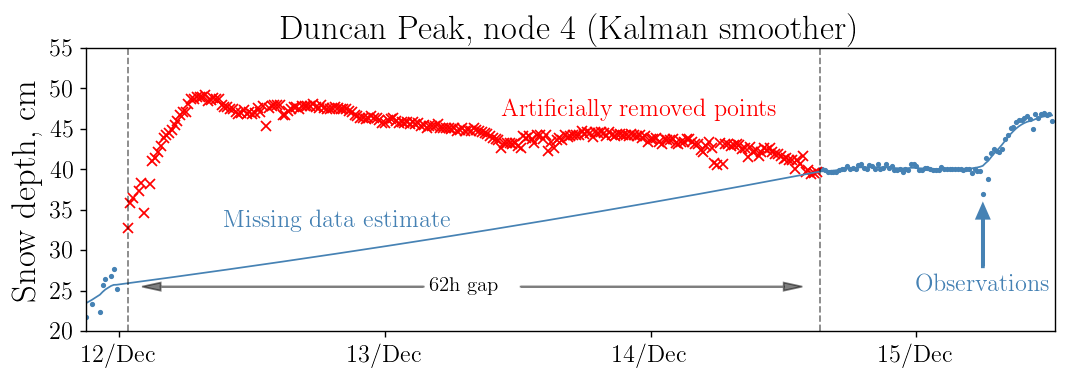

In [654]:
#test_mse = np.nanmean(np.square(Y[0, (ti_gap-ti):(tf_gap-ti)] - Y_hat[0, (ti_gap-ti):(tf_gap-ti)]))

plt.figure(figsize=(10, 3))

plt.plot(times[ti:tf], 0.1*Y_nand_ks[0, :], '.', markersize=4.0, color=colors[0])
# Mark removed points with xs
plt.plot(times[ti_gap:tf_gap], 0.1*Y_ks[0, (ti_gap-ti):(tf_gap-ti)], 'x', markersize=6.0, color="r")
plt.plot(times[ti:tf], 0.1*Y_hat_ks[0, :], '-', linewidth=1, color=colors[0])

# Mark beginning and end of time gap
plt.plot(2*[times[ti_gap]], [20, 55], '--k', alpha=0.5, linewidth=1)
plt.plot(2*[times[tf_gap]], [20, 55], '--k', alpha=0.5, linewidth=1)
plt.text(times[ti_gap+109], 25, str((times[tf_gap] - times[ti_gap]).astype('timedelta64[h]'))[0:2] + "h gap")
plt.arrow(times[ti_gap+107], 25.5, -0.99, 0, head_width=1, head_length=0.07, fc='k', ec='k', alpha=0.5)
plt.arrow(times[ti_gap+142], 25.5, 0.99, 0, head_width=1, head_length=0.07, fc='k', ec='k', alpha=0.5)

### Formatting
plt.xlim(times[ti], times[tf])
plt.ylim(20, 55)

plt.ylabel("Snow depth, cm", fontsize=20)
plt.title(r"Duncan Peak, node %i (Kalman smoother)" % (sensor_of_interest+1), fontsize=20)

# Change tick font size
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
# Use fewer x ticks
plt.xticks(times[ti+12:tf:96], [pd.to_datetime(t).strftime('%d/%b') for t in times[ti+12:tf:96]])

### Mark the plot up
plt.text(times[ti+150], 46.5, "Artificially removed points", fontsize=14, color="r")
plt.text(times[ti+300], 25, "Observations", fontsize=14, color=colors[0])
plt.arrow(times[ti+324], 28, 0, 6, head_width=0.04, head_length=1.5, linewidth=2, alpha=1, fc=colors[0], ec=colors[0])
plt.text(times[ti+50], 33, "Missing data estimate", fontsize=14, color=colors[0])

plt.savefig("../presentations/uc_water/figures/ks_missing_data.png", bbox_inches='tight', dpi=500)

In [879]:
print np.sqrt(np.nanmean(np.square(0.1*(Y_ks[0, (ti_gap-ti):(tf_gap-ti)] - Y_hat_ks[0, (ti_gap-ti):(tf_gap-ti)]))))

13.4225314297


# Algorithm steps

In [565]:
n_LF = 3
max_it = 0

sensors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ti, tf = 18100, 18350 #7400, 7525
Y_algo = y_hs_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat_algo, sigma_smooth, _, _, _, _, _, Cs_algo, Ds_algo, _, _ = ssm_em_stable(Y_algo, U, V, ss, s_list, n_LF, max_it)

Y_hat_algo = np.einsum("tij,jt->it", Cs_algo[ss], X_hat_algo) + np.einsum("tij,jt->it", Ds_algo[ss], V)

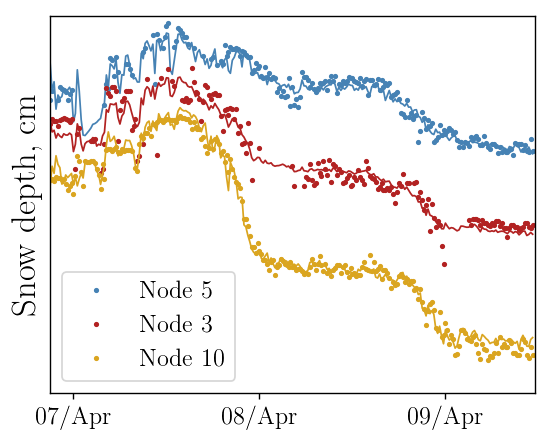

In [571]:
plt.figure(figsize=(5, 4))

for s, c in zip([4, 2, 9], colors):
    plt.plot(times[ti:tf], 0.1*Y_algo[s, :], '.', markersize=4.0, color=c, label="Node %i" % (s+1))
    # Mark removed points with xs
    plt.plot(times[ti:tf], 0.1*Y_hat_algo[s, :], '-', linewidth=1, color=c)

### Formatting
plt.xlim(times[ti], times[tf])
plt.ylim(-5, 35)
plt.legend(loc="lower left", fontsize=14)

plt.ylabel("Snow depth, cm", fontsize=20)
plt.yticks([])
#plt.title(r"Duncan Peak, node %i" % sensor_of_interest, fontsize=30)

# Change tick font size
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
# Use fewer x ticks
plt.xticks(times[ti+12:tf:96], [pd.to_datetime(t).strftime('%d/%b') for t in times[ti+12:tf:96]])

plt.savefig("../presentations/uc_water/figures/algo_%i.png" % max_it, bbox_inches='tight', dpi=500)

# Sensor noise estimate

In [725]:
n_LF = 1
sensors = [2]
max_it = 100

ti, tf = 0, 200

Y_noise = y_hs_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat_noise, _, _, _, _, _, _, Cs_noise, Ds_noise, _, Rs_noise = ssm_em_stable(Y_noise, U, V, ss, s_list, n_LF, max_it)

Y_hat_noise = np.einsum("tij,jt->it", Cs_noise[ss], X_hat_noise) + np.einsum("tij,jt->it", Ds_noise[ss], V)

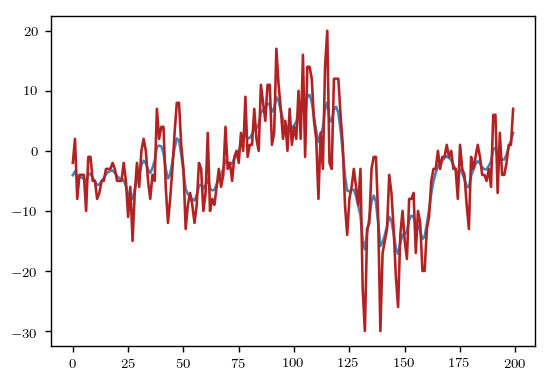

In [726]:
plt.plot(Y_hat_noise.T)
plt.plot(Y_noise.T)

In [727]:
np.sqrt(Rs_noise)

array([[[ 4.65682126]]])

# Regressing summer "snow depth" onto $\sum_t {P_{\rm solar}}_t$
Sensor with good summer data
* 00-17-0d-00-00-38-29-26.csv
* 00-17-0d-00-00-60-2b-3f.csv

In [313]:
y_hs_ktl = pd.read_csv("../raw_data/feather_data/KTL/snowdepth/00-17-0d-00-00-38-29-26.csv", delimiter=";")
y_hs_ktl.columns = ["time", "hs"]
y_hs_ktl["time"] = pd.to_datetime(y_hs_ktl["time"])

y_solar_ktl = pd.read_csv("../raw_data/feather_data/KTL/solar_rad/00-17-0d-00-00-60-1e-58.csv", delimiter=";")
y_solar_ktl.columns = ["time", "solar"]
y_solar_ktl["time"] = pd.to_datetime(y_solar_ktl["time"])

y_temp_ktl = pd.read_csv("../raw_data/feather_data/KTL/air_temp/00-17-0d-00-00-38-29-26.csv", delimiter=";")
y_temp_ktl.columns = ["time", "temp"]
y_temp_ktl["time"] = pd.to_datetime(y_temp_ktl["time"])
# Replace "null" strings
y_temp_ktl.replace("null", np.nan, inplace=True)
y_temp_ktl.replace("NaN", np.nan, inplace=True)
y_temp_ktl["temp"] = pd.to_numeric(y_hs_solar["temp"], errors="coerce")

y_hs_solar_temp = pd.merge(y_hs_ktl, y_solar_ktl, how="outer", on="time", suffixes=("", ""))
y_hs_solar_temp = pd.merge(y_hs_solar_temp, y_temp_ktl, how="outer", on="time", suffixes=("", ""))
y_hs_solar_temp.sort_values("time", inplace=True)

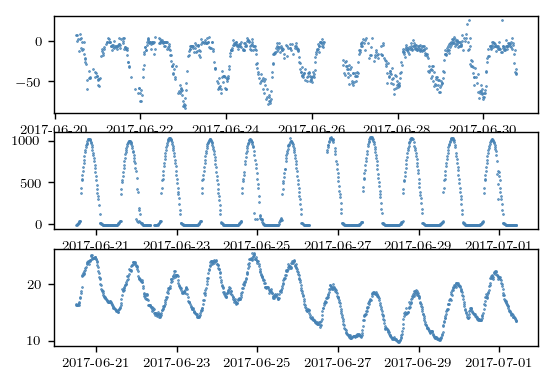

In [329]:
ti, tf = 29550, 30600

plt.subplot(3, 1, 1)
plt.plot_date(y_hs_solar_temp["time"].values[ti:tf], y_hs_solar_temp["hs"].values[ti:tf], markersize=0.5)
plt.subplot(3, 1, 2)
plt.plot_date(y_hs_solar_temp["time"].values[ti:tf], y_hs_solar_temp["solar"].values[ti:tf], markersize=0.5)
plt.subplot(3, 1, 3)
plt.plot_date(y_hs_solar_temp["time"].values[ti:tf], y_hs_solar_temp["temp"].values[ti:tf], markersize=0.5)

In [468]:
ti = 29550-5 #22981+49ti, tf = 29550, 30600
tf = ti + 96*6

n_obs_day = 55
offset = 0

# Get day and night times
day_times = np.array([y_hs_solar_temp["time"].values[ti+t:ti+t+n_obs_day] for t in range(0, tf-ti, 96)])
night_times = np.array([y_hs_solar_temp["time"].values[ti+t+n_obs_day:ti+t+96] for t in range(0, tf-ti, 96)])

# Take day's snow depth
day_hs = np.array([y_hs_solar_temp["hs"].values[ti+t:ti+t+n_obs_day] for t in range(0, tf-ti, 96)])

# Take night's snow depth and temperature
night_hs = np.array([y_hs_solar_temp["hs"].values[ti+t+n_obs_day:ti+t+96] for t in range(0, tf-ti, 96)])
night_temp = np.array([y_hs_solar_temp["temp"].values[ti+t+n_obs_day:ti+t+96] for t in range(0, tf-ti, 96)])

# Take cumsum of each day's radiation
sum_day_rad = np.array([np.nancumsum(np.power(y_hs_solar_temp["solar"].values[ti+t+offset:ti+t+n_obs_day+offset], 0.25)) for t in range(0, tf-ti, 96)])

# Get indices of observed snow depths
day_obs_idx = np.where(~np.isnan(day_hs.flatten()))[0]
night_obs_idx = np.where(~np.isnan(night_hs.flatten()))[0]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(sum_day_rad.flatten()[day_obs_idx].reshape(-1, 1), day_hs.flatten()[day_obs_idx].reshape(-1, 1))

# Make predictions using the testing set
day_hs_pred = regr.predict(sum_day_rad.flatten()[obs_idx].reshape(-1, 1))

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


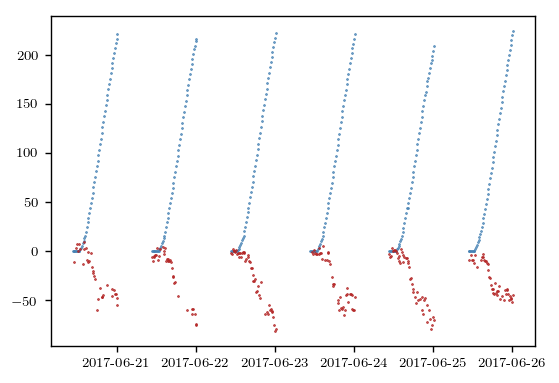

In [379]:
plt.plot_date(day_times.flatten(), sum_day_rad.flatten(), markersize=0.5)
plt.plot_date(day_times.flatten(), day_hs.flatten(), markersize=0.5)

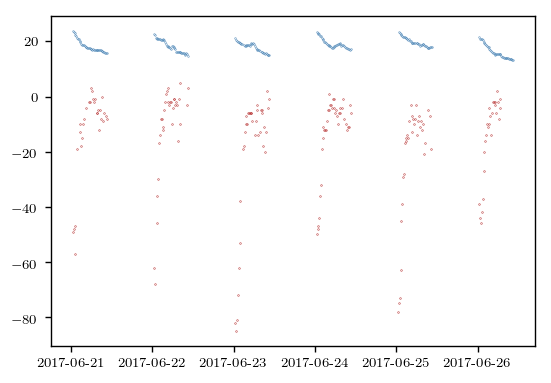

In [462]:
plt.plot(night_times.flatten(), night_temp.flatten(), '.', markersize=0.5)
plt.plot(night_times.flatten(), night_hs.flatten(), '.', markersize=0.5)

In [483]:
# Fit HS = exp(a + b t)
b, a = np.polyfit(np.array(6*range(41))[night_obs_idx], np.log(-night_hs.flatten()+1.01*np.nanmax(night_hs.flatten()))[night_obs_idx], 1)

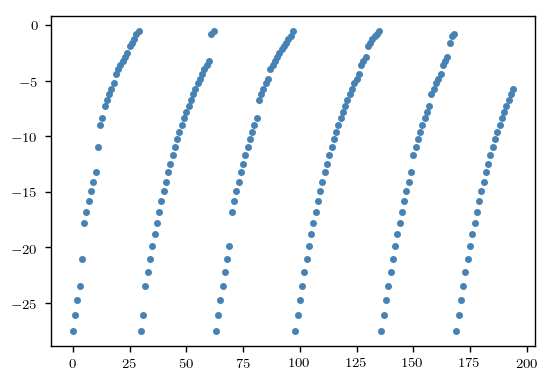

In [489]:
plt.plot(np.nanmax(night_hs.flatten())-np.exp(a + b * np.array(6*range(41)))[night_obs_idx], '.')

([<matplotlib.axis.XTick at 0x139b5f250>,
 <a list of 6 Text xticklabel objects>)

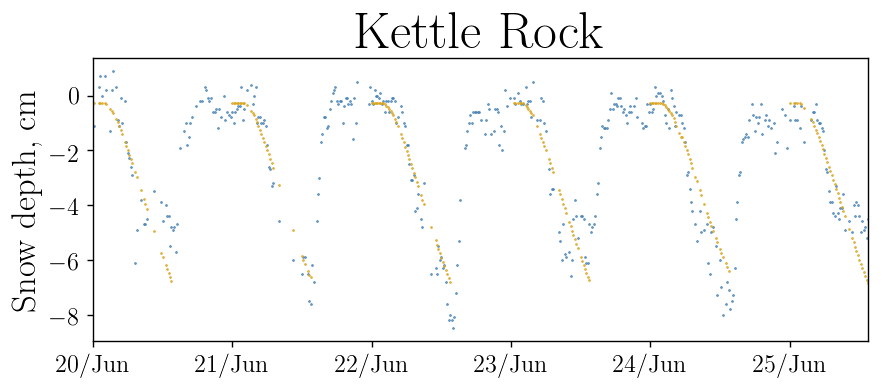

In [492]:
plt.figure(figsize=(8, 3))

plt.plot_date(y_hs_solar_temp["time"].values[ti:tf], 0.1*y_hs_solar_temp["hs"].values[ti:tf], markersize=0.5, color=colors[0])
# Day fit to sum of P_solar
plt.plot_date(day_times.flatten()[day_obs_idx], 0.1*day_hs_pred.flatten(), markersize=0.5, color=colors[2])
# Night fit to exp(a + b t)
#plt.plot_date(night_times.flatten()[night_obs_idx], 0.1*np.nanmax(night_hs.flatten())-0.1*np.exp(a + b * np.array(6*range(41)))[night_obs_idx], markersize=0.5, color=colors[1])

### Formatting
plt.xlim([day_times[0][0], day_times[-1][-1]])
#plt.ylim(-15, 50)

plt.ylabel("Snow depth, cm", fontsize=20)
plt.title(r"Kettle Rock", fontsize=30)

# Change tick font size
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
# Use fewer x ticks
xtick_times = y_hs_solar["time"].values[ti:tf:96]
plt.xticks(xtick_times, [pd.to_datetime(t).strftime('%d/%b') for t in xtick_times])

# Ideas on anomalies

In [447]:
times[ti+2]

numpy.datetime64('2015-05-01T00:00:00.000000000')

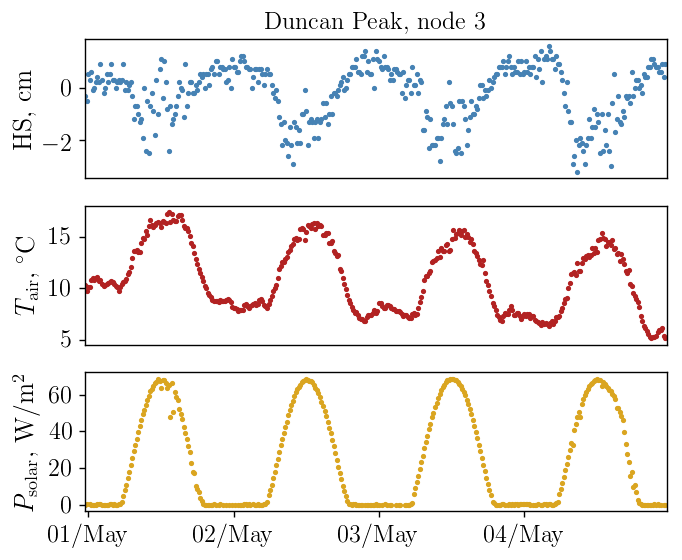

In [573]:
plt.figure(figsize=(6, 5))

ti = 20350
tf = ti + 4*96

ms = 4
s = 2

plt.subplot(3, 1, 1)
plt.plot(times[ti:tf], 0.1*y_hs_raw[ti:tf, s], '.', markersize=ms, color=colors[0])
plt.xlim(times[ti], times[tf])
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
plt.ylabel("HS, cm", fontsize=15)
plt.xticks([])
plt.title(wsn_name + ", node %i" % (s+1), fontsize=14)

plt.subplot(3, 1, 2)
plt.plot(times[ti:tf], y_t_raw[ti:tf, s], '.', markersize=ms, color=colors[1])
plt.xlim(times[ti], times[tf])
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
plt.ylabel(r"$T_{\rm air}$, $^\circ$C", fontsize=15)
plt.xticks([])

plt.subplot(3, 1, 3)
plt.plot(times[ti:tf], y_rad_raw[ti:tf, 10]/14.91, '.', markersize=ms, color=colors[2])
plt.xlim(times[ti], times[tf])
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
plt.ylabel(r"$P_{\rm solar}$, W/m$^2$", fontsize=15)

### Formatting
# Change tick font size
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
# Use fewer x ticks
plt.xticks(times[ti+2:tf:96], [pd.to_datetime(t).strftime('%d/%b') for t in times[ti+2:tf:96]])

plt.savefig("../presentations/uc_water/figures/heating_cooling.png", bbox_inches='tight', dpi=500)

# Scratch